# Learning objective

This notebook demonstrates the band-gap phenomenon exhibited by the linear Klein&ndash;Gordon equation. Specifically, it illustrates what happens when one attempts to drive waves at frequencies above and below the cutoff frequency.

# Preliminaries

In [1]:
# interactive plots setup
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# sympy setup
import sympy as sp
sp.init_printing()
from sympy.vector import *

# ploting customizations
from matplotlib import pyplot as plt
size=16
params = {'legend.fontsize': 'large',
#          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.875,
          'ytick.labelsize': size*0.875,
          'axes.titlepad': 25,
          'animation.embed_limit': 2**128}
plt.rcParams.update(params)
%matplotlib inline
from matplotlib import colormaps
from mpl_toolkits.mplot3d import axes3d

# for animations
from matplotlib import animation, rc
from IPython.display import HTML

# numerics
import numpy as np
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq
from scipy.interpolate import griddata

# to save plots as files and download them
#from google.colab import files

## Credit

Initial version written by [Ivan C. Christov](http://christov.tmnt-lab.org), Purdue University.

# The Klein--Gordon equation

Consider the so-called [Klein&mdash;Gordon equation](https://en.wikipedia.org/wiki/Klein%E2%80%93Gordon_equation) with normalized coefficients (dimensionless):
$$ u_{tt} - u_{xx} = - u. $$
This equation arises as a relativistic wave equation in quantum mechanics, or as a linearlization of the [sine-Gordon equation](https://en.wikipedia.org/wiki/Sine-Gordon_equation) for small values of the field variable (angle).

The Klein&mdash;Gordon equation exhibits a [band-gap](https://en.wikipedia.org/wiki/Band_gap) phenomenon in the sense that the dispersion relation
$$ k(\omega) = \sqrt{\omega^2 - 1}$$
yield _purely imaginary_ $k$ for $\omega < 1$, which does not allow harmonic waves to propagate.

To substantiate this statement, we solve the KG equation numerically on the spatial interval $x_\mathrm{min}\le x \le x_\mathrm{max}$ up to $t=t_\mathrm{max}$, and plot the results.

In [2]:
# spatial interval
xmin = 0
xmax = 10

# number of grid points in discretization
# use a power of 2 to make spatial ffts looks nice
N = 512
# grid spacing
h = (xmax-xmin)/N

# simulation run time
tmax = 20

## The boundary conditions

We will impose a Dirichlet BC at the left end (to force a wave into the domain) and a transmission BC at the right end (to ensure right-going waves leave the domain without reflection):
$$ \begin{align}
u(x_\mathrm{min},t) &= \sin(\omega t),\\
u_t(x_\mathrm{max},t) &= -u_x(x_\mathrm{max},t), \end{align} $$

To force $u$ sinusoidally at the left domain endpoint, we define a function that returns _both_ $u(x_\mathrm{min},t)$ and  $u_t(x_\mathrm{min},t)=v(x_\mathrm{min},t)$.

In [3]:
# the forcing frequency at the boundary
# it is dimensionless and normalized
# so we are interested in omegabc > or < 1
omegabc = 0.5

def leftbc(t):
  ulbc = np.sin(omegabc*t)
  vlbc = omegabc*np.cos(omegabc*t)
  return ulbc, vlbc

Change the BC frequency above and re-run the simulation to see the band-gap phenomenon.

## The initial condition

For simplicity, we take a zero initial condition, since the wave is introduced at the boundary.

In [4]:
# store the initial conditions (ICs) on u, v in a single vector
uvic = np.zeros(2*N)

# set the j = 0 elements to match the BCs
uvic[0], uvic[N] = leftbc(0)

# Numerical solution

First, we write the second-order KG equation as an equivalent first-order _system_:
$$ \begin{align} u_{t} &= v\\ v_t &= u_{xx} - u. \end{align}$$

The semi-discrete problem (using the [method of lines](https://reference.wolfram.com/language/tutorial/NDSolveMethodOfLines.html)) we wish to solve is
$$ \left. \begin{align} \dot{u}_j &= v_j,\\ \dot{v}_j &= \left(\frac{u_{j+1} +2u_j - u_{j-1}}{h^2}\right) - u_j \end{align}\right\}\quad j=1,\dots,N-2, $$
so that $u_j(t) \approx u(x_j,t)$.

At the boundary nodes $j=0$ and $j=N-1$, we use the specified BCs and [forward/backwards difference formul&aelig;](https://www.dam.brown.edu/people/alcyew/handouts/numdiff.pdf) for the derivatives (this ensures that we do not need to know $u_{-1}$ or $u_{N}$ as in our previous codes).

In [5]:
# ODE system right-hand side
def kleingordon(t,u):
  F = np.empty(2*N)

  # boundary nodes require special care
  ulbc, vlbc = leftbc(t)
  F[0] = vlbc
  # set u_t = -u_x at x_max to ensure transmission of waves
  F[N-1] = -(3*u[N-1] - 4*u[N-2] + u[N-3])/(2*h)
  # use forward difference formula for u_xx at x_min
  F[N] = (2*ulbc - 5*u[1] + 4*u[2] - u[3])/h**3 - ulbc
  # use backward difference formula for u_xx at x_max
  F[2*N-1] = (2*u[N-1] - 5*u[N-2] + 4*u[N-3] - u[N-4])/h**3 - u[N-1]

  # interior nodes, per the ODE formula
  for j in range(1,N-1):
    F[j]   = u[j+N]
    F[j+N] = (u[j+1] - 2*u[j] + u[j-1])/h**2 - u[j]

  return F

In [6]:
# try: test different tolerances for the integrator, changing reltol
reltol = 1e-6

# simulate the PDE
sol = solve_ivp(fun=kleingordon,
                t_span=[0,tmax], y0=uvic,
                method='DOP853', rtol=reltol, dense_output=True)

# Results and visualization

## Static plot

First, just a quick static plot of the solution at the final time.

NOTE: for this omegabc, ks is imaginary!



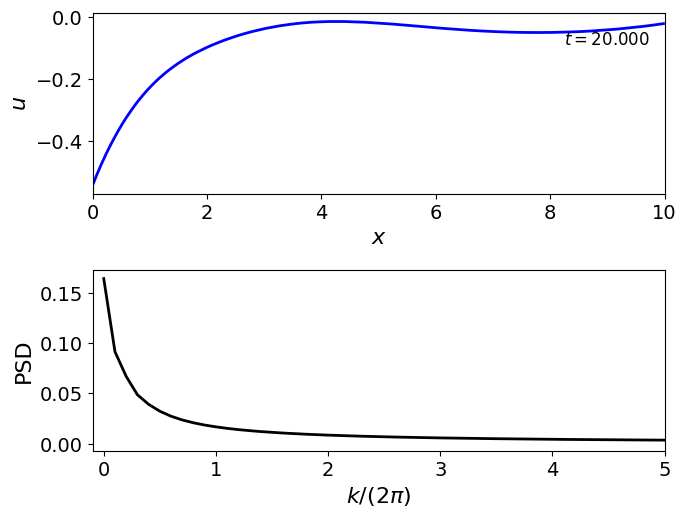

In [12]:
tplot = 20

xj = np.linspace(xmin,xmax,num=N,endpoint=False)
uj = sol.sol(tplot)[0:N]

# compute spatial Fourier spectrum
yf = fft(uj,512)
xf = fftfreq(N, h)[:N//2]

# the expected spatial wave number for the given BC
# is found from the dispersion relation
if omegabc**2-1 >= 0:
  ks = np.sqrt(omegabc**2-1)/(2*np.pi)
else:
  ks = np.nan
  print('NOTE: for this omegabc, ks is imaginary!\n')

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(7,5))
ax1.plot(xj, uj, lw=2, color='blue')
ax1.set_ylabel('$u$')
#ax.set_ylim(-1,3)
ax1.set_xlabel('$x$')
ax1.set_xlim(xmin,xmax)
# nice label to show time
ax1.text(0.825, 0.825, f'$t=${tplot:.3f}', size='large',
        #bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),
        transform=ax1.transAxes, animated=True)
# so axes labels aren't cut off
plt.tight_layout()

ax2.plot(xf,2.0/N * np.abs(yf[0:N//2]), lw=2, color='black')
# add vertical line for expected k value
ax2.plot(ks**np.ones(10), np.linspace(0,1,10), ls='dashed', color='gray')
ax2.plot(ks**np.ones(10), np.linspace(0,1,10), ls='dashed', color='gray')
ax2.set_ylabel('PSD')
ax2.set_xlabel(r'$k/(2\pi)$')
ax2.set_xlim(-0.1,5);

The bottom plot shows a power spectrum density (PSD) computed from a _spatial_ FFT of $u(x,t_\mathrm{plot})$. The dashed vertical line is the expected wave number $k(\omega)$ (sholud it exists/be real) of the resulting wave.

## Animation

Next, we visualize our results using our snazzy animation tools.

In [8]:
# define how to sample the solution in time
tnum = 100
dt = (tmax-0)/(tnum-1)
tspan = np.array(range(0,tnum))*dt

In [9]:
# set up the figure and axes
fig, ax = plt.subplots()
ax.set_ylabel('$u$')
ax.set_xlabel('$x$')
ax.set_xlim(xmin,xmax)
ax.set_ylim(-1.2,1.2)
# nice dynamic label to show time
ttl = ax.text(0.825, 0.925, '', size='large',
              #bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),
              transform=ax.transAxes, animated=True)
# so axes labels aren't cut off
plt.tight_layout()
plt.close()

# initialize plot objects with some dummy data (replaced in animation)
line, = ax.plot(xj, 0*xj, color='blue', linewidth=2)

# animation function called sequentially by `FuncAnimation' below
def animate(it):
  uj = sol.sol(it*dt)[0:N]
  line.set_data(xj, uj)
  ttl.set_text(f'$t={it*dt:.3f}$')

  return (line, ttl, )

framran = range(0,tnum)
anim = animation.FuncAnimation(fig, animate, frames=framran,
                               interval=100, blit=True)

# this is necessary to get the animation to work on Google's Colab
rc('animation', html='jshtml')
anim

## Space-time plot

In [10]:
# define how to sample the solution in time
tnum = 200
dt = (tmax-0)/(tnum-1)
tspan = np.array(range(0,tnum))*dt

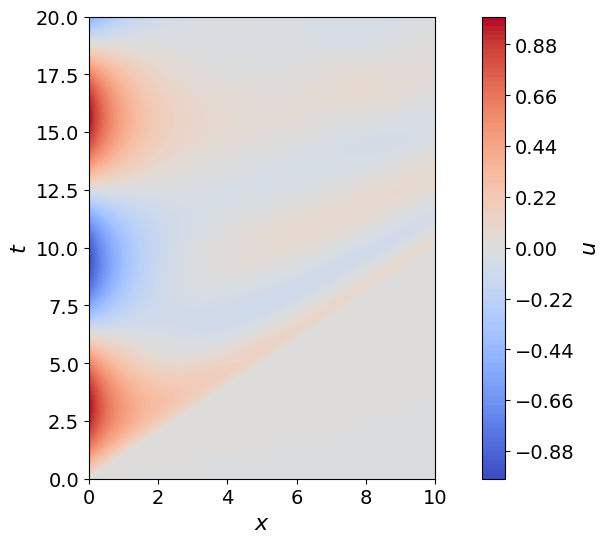

In [11]:
# make a matrix of space-time values u(x,t)
ujp = np.empty((tnum,N))
for it in range(0,tnum):
  ujp[it,:] = sol.sol(it*dt)[0:N]

# make cool plot, try also cmap='RdGy'
fig, ax = plt.subplots(figsize=(12, 6))
plt.contourf(xj, tspan, ujp, 100, cmap='coolwarm')
plt.colorbar(label='$u$')
ax.set_ylim(0,tmax)
ax.set_ylabel('$t$')
ax.set_xlim(xmin,xmax)
ax.set_xlabel('$x$')
ax.set_aspect(1/1.5)